In [1]:
import sys
sys.path.extend(["../..", "../../src"])

In [2]:
from tqdm import tqdm
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import torch as th
from torch.utils.data import TensorDataset


from src.loss import phase_insensitive_loss_cvx
from src.gd_opt import learn_phase_insensitive_povm
from src.quantum import rand_DV_diag_povm, diag_povm_fidelity, get_qubit_probe_states, apply_t1_to_populations, diag_mse_norm
from src.utils import check_diag_povm, square_normalize
from src.custom_types import Hyperparameters

matplotlib.rcParams.update({"font.size": 16})
plt.rcParams["figure.dpi"] = 125 #200  # set fig resolution
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

seed = 42  # for reproducibility
th.manual_seed(seed);

### Nosiy datasets (noise in probe states)

In [3]:
noise_coeffs = np.linspace(0, 1, 8)
print(noise_coeffs)

use_depolaraizion_noise = True  # if false T1 error/noise (relaxation) is used
num_qubits = 8
device = 'cpu'
lam_l1 = 0e-5
cco_solver = 'MOSEK'
avg_fids_cco = []
avg_mses_cco = []

gd_trials = 10
avg_fids_gd_sample = []
avg_mses_gd_sample = []
iters_cco = []

prob_norm_fn = "smax"

hyperparams = Hyperparameters(lr=0.02, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=100, batch_size=25)

[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]


In [4]:
pbar = tqdm(noise_coeffs, desc="Performing noise experiments")

for noise_coeff in pbar:
    current_item_status = f"Processing λ={noise_coeff}"
    # Update the postfix text with a dictionary
    pbar.set_postfix({"status": current_item_status})
    
    # Random Z-basis diagonal detector POVM
    true_povm = rand_DV_diag_povm(num_qubits=num_qubits)
    #true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T.to(device=device, dtype=th.float64)
    # NOTE: we take the transpose since originally the rows are the povm diagonals when using vstack
    true_povm = th.vstack( true_povm ).T.to(device=device, dtype=th.float64)

    # We just need the probs (this only works for kets for dms we'd need to extract the diagonals)
    probes = get_qubit_probe_states(num_qubits, return_dm=False, povm_is_diag=True, device=device).abs().to(th.float64) ** 2

    if use_depolaraizion_noise:
        # apply depolariaztion noise (only considering how diagonals of density matrix change since our POVM elements are diagonal)
        probes_noisy = (1-noise_coeff)*probes + (noise_coeff * th.ones(2**num_qubits) / 2**num_qubits )
    else: 
        probes_noisy = apply_t1_to_populations(probes, noise_coeff, num_qubits)

    targets = probes_noisy @ true_povm  
    # `probes` dimension is num probe states x hilbert dim
    # `targets` dimensions is num probes x num povm elements 
    M, N, = probes.shape[1], targets.shape[1]
    
    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)

    avg_fids_gd_M = []
    avg_mses_gd_M = []
    for i in range(gd_trials):
        
        logits = th.rand((M, N)) - 1
        logits = logits.to(device)
        logits.requires_grad = True    
        
        logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, 0.0, False, None, lam_l1, prob_norm_fn)

        if prob_norm_fn == "sqr":
            Pi = square_normalize(logits).to(device)  # rows are probability vectors so apply normalizaion along them
        else:    
            Pi = th.softmax(logits, dim=1).to(device)  # rows are probability vectors so apply softmax along them
        
        if check_diag_povm(Pi.T, tol=1e-4) is not True:
            print(f"WARNING: Gradient descent got solution POVM for {num_qubits} qubits which is below error tolerance.")

        Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_fids_gd_M.append(sum(Fs)/len(Fs))

        mses = [ diag_mse_norm(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_mses_gd_M.append(sum(mses)/len(mses))

    avg_fids_gd_sample.append(avg_fids_gd_M)
    avg_mses_gd_sample.append(avg_mses_gd_M)

    Pi, prob, iters = phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), 0.0, cco_solver, lam_l1)
    iters_cco.append(iters)
    Pi = th.tensor(Pi)

    if check_diag_povm(Pi.T, tol=1e-4) is not True:
        print(f"WARNING: {cco_solver} got solution POVM for {num_qubits} qubits which is above error tolerance.")

    Fs = [ diag_povm_fidelity(Pi[:, i].to('cpu'), true_povm[:, i].to('cpu')) for i in range(true_povm.shape[1]) ]
    avg_fids_cco.append(sum(Fs)/len(Fs))

    mses = [ diag_mse_norm(Pi[:, i].to('cpu'), true_povm[:, i].to('cpu')) for i in range(true_povm.shape[1]) ]
    avg_mses_cco.append(sum(mses)/len(mses))

    avg_fids_gd_M = []

Performing noise experiments: 100%|██████████| 8/8 [02:59<00:00, 22.49s/it, status=Processing λ=1.0]                


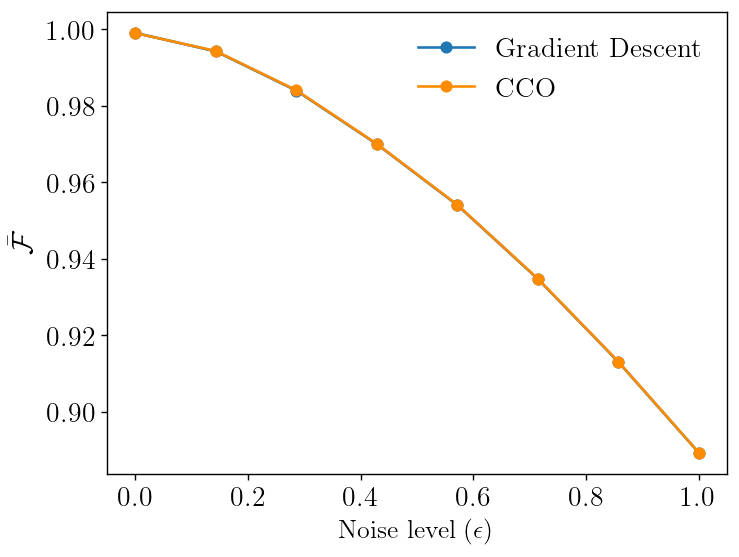

In [5]:
arr = np.array(avg_fids_gd_sample)
mean = arr.mean(axis=1)
lower = mean - np.std(arr, axis=1)
upper = mean + np.std(arr, axis=1)

plt.plot(noise_coeffs, mean, color='C0', label=r'\textrm{Gradient Descent}', marker="o")
plt.fill_between(noise_coeffs, lower, upper, color='C0', alpha=0.3)

plt.plot(noise_coeffs, avg_fids_cco, label=r'\textrm{CCO}', marker="o", color="darkorange")

plt.xlabel(r"\textrm{Noise level} $(\epsilon)$", fontsize=15)
# plt.xticks(noise_coeff)
plt.ylabel(r"$\bar{\mathcal{F}}$", fontsize=17.0)
# plt.yscale("log")

plt.legend(fancybox=True, ncol=1, frameon=False)
plt.savefig("../figs/dv/dv_noise_fidelity.png", dpi=300, bbox_inches='tight')
plt.show();

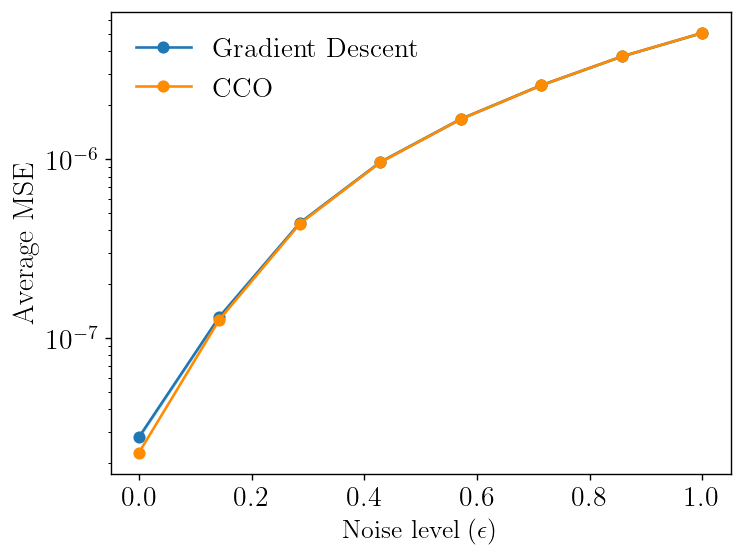

In [6]:
arr = np.array(avg_mses_gd_sample)
mean = arr.mean(axis=1)
lower = mean - np.std(arr, axis=1)
upper = mean + np.std(arr, axis=1)

plt.plot(noise_coeffs, mean, color='C0', label=r'\textrm{Gradient Descent}', marker="o")
plt.fill_between(noise_coeffs, lower, upper, color='C0', alpha=0.3)

plt.plot(noise_coeffs, avg_mses_cco, label=r'\textrm{CCO}', marker="o", color="darkorange")

plt.xlabel(r"\textrm{Noise level} $(\epsilon)$", fontsize=15)
# plt.xticks(noise_coeff)
plt.ylabel(r"$\textrm{Average MSE}$", fontsize=17.0)
plt.yscale("log")

plt.legend(fancybox=True, ncol=1, frameon=False)
plt.savefig("../figs/dv/dv_noise_mse.png", dpi=300, bbox_inches='tight')
plt.show();

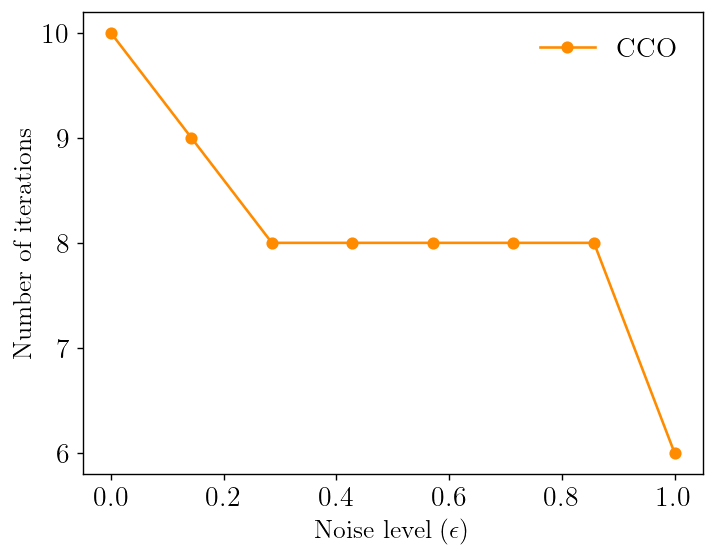

In [7]:
plt.plot(noise_coeffs, iters_cco, label=r'\textrm{CCO}', marker="o", color="darkorange")
plt.xlabel(r"\textrm{Noise level} $(\epsilon)$", fontsize=15)
plt.ylabel(r"$\textrm{Number of iterations}$", fontsize=15.0)
plt.legend(fancybox=True, ncol=1, frameon=False);

plt.savefig("../figs/dv/dv_noise_iters.png", dpi=300, bbox_inches='tight')